# Анализ данных сервиса аренды самокатов

### Загрузка данных

В основных данных есть информация о пользователях, их поездках и подписках. Всего 3 таблицы с данными.

Пользователи:

user_id - уникальный идентификатор пользователя  
name - имя пользователя   
age - возраст   
city - город   
subscription_type - тип подписки (free, ultra)   


Поездки:

user_id - уникальный идентификатор пользователя  
distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)  
duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»  
date - дата совершения поездки  

Подписки:
  
subscription_type - тип подписки  
minute_price - стоимость одной минуты поездки по данной подписке  
start_ride_price - стоимость начала поездки  
subscription_fee - стоимость ежемесячного платежа

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from scipy import stats as st
from scipy.stats import binom

pd.set_option('display.max_columns', None)

In [2]:
users = pd.read_csv('users_go.csv')
rides = pd.read_csv('rides_go.csv')
subscriptions = pd.read_csv('subscriptions_go.csv')

Посмотрим внешне на эти данные

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [4]:
users.sample(5)

,user_id,name,age,city,subscription_type
1239,1240,Анжелика,25,Ростов-на-Дону,free
399,400,Петр,21,Ростов-на-Дону,ultra
923,924,Мария,23,Пятигорск,free
681,682,Евгения,23,Сочи,ultra
164,165,Оксана,31,Краснодар,ultra


In [5]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [6]:
rides.sample(5)

,user_id,distance,duration,date
7744,789,2935.839496,20.009398,2021-05-25
13802,1231,3437.494853,21.932680,2021-12-24
4925,530,3097.700626,22.275860,2021-08-29
16709,1436,661.887919,16.836663,2021-08-26
17328,1484,2818.089185,14.038763,2021-05-19


In [7]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [8]:
subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


По общей информации о каждом датафрейме можно отметить, что пропусков в них нет. Типы данных почти всех столбцов корректные, необходимо заменить тип данных в столбце date на datetime. Таблица subscriptions не нуждается в предобработке.

 Возможно есть дубликаты явные/неявные, аномалии.

### Предобработка данных

Рассмотрим таблицу users на предмет дубликатов.

In [9]:
users.sample(5)

,user_id,name,age,city,subscription_type
1114,1115,Анна,29,Екатеринбург,free
313,314,Святогор,28,Екатеринбург,ultra
1144,1145,Назар,22,Сочи,free
1074,1075,Ника,33,Тюмень,free
976,977,Амалия,22,Москва,free


In [10]:
users.duplicated().sum()

31

In [11]:
users.drop_duplicates(inplace=True)
users.duplicated().sum()

0

 Рассмотрим таблицу rides на наличие дубликатов и заменим тип данных, где необходимо

In [12]:
rides.sample(5)

,user_id,distance,duration,date
13530,1212,4890.429345,27.339110,2021-12-27
5215,560,3205.883627,24.314883,2021-12-12
2345,250,739.222119,8.168095,2021-02-20
4319,465,3613.695262,24.678594,2021-04-14
6171,661,3418.818022,13.796267,2021-05-27


In [13]:
rides.duplicated().sum()

0

Дубликатов нет, столбец date переведем в тип данных datetime

In [14]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Добавим новый столбец month - месяц поездки. Для начала проверим, за какой период данные

In [15]:
rides['date'].dt.year.unique()

array([2021])

Данные только за 2021 год, можем спокойно группировать по месяцам, без группировки по годам.

In [16]:
rides['month'] = rides['date'].dt.month
rides.sample(5)

,user_id,distance,duration,date,month
5782,616,381.179906,4.633628,2021-07-02,7
3982,430,2945.343619,17.545208,2021-03-06,3
7763,790,2447.549377,20.790198,2021-07-11,7
5932,632,3107.841000,15.968851,2021-03-26,3
5387,577,2736.084558,15.462049,2021-02-17,2


Рассмотрим описательные характеристики на наличие аномалий.

In [17]:
rides.describe()

,user_id,distance,duration,month
count,18068.000000,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011,6.486772
std,434.734317,1116.831209,6.091051,3.437410
min,1.000000,0.855683,0.500000,1.000000
25%,487.000000,2543.226360,13.597563,4.000000
50%,889.000000,3133.609994,17.678395,6.000000
75%,1213.250000,3776.222735,21.724800,9.000000
max,1534.000000,7211.007745,40.823963,12.000000


В столбце duration есть подозрительный минимум - 0.5 минуты продолжительность поездки

In [18]:
rides.query('duration < 1')

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


В таблице есть 95 поездок, продолжительностью 0.5 минут. Это странно, так как даже при скорости 50км/час и хороших дорогах, за минуту такой самокат может проехать 833 метра. Тогда за пол минуты - около 400 метров, а мы видим, что у таких поездок дистанция варьируется от 4 до 7 км. Пока оставим как есть и разберемся с ними на этапе исследовательского анализа.


### Исследовательский анализ данных

*Опишем и визуализируем общую информацию о пользователях и поездках:
3.1 частота встречаемости городов;  
3.2 соотношение пользователей с подпиской и без подписки;  
3.3 возраст пользователей;  
3.4 расстояние, которое пользователь преодолел за одну поездку;  
3.5 продолжительность поездок*

Напишем функцию построения графиков боксплот и гистограммы

In [19]:
def get_histogram_boxplot(column, r=None):
    fig, (ax, ax2) = plt.subplots(2, figsize=(8, 5))
    sns.boxplot(x=column, orient='H')
    ax.hist(column,
            alpha=0.8,
            color='green',
            bins=100,
            range=r)

    ax.set_ylabel('Частота')
    ax.set_xlabel(column.name)
    ax.grid()
    ax2.grid()
    ax.set(xlabel='')
    ax2.set_ylabel('Частота')

    plt.suptitle(f'Распределение значений {column.name}')

    print(column.describe())

#### Частота встречаемости городов

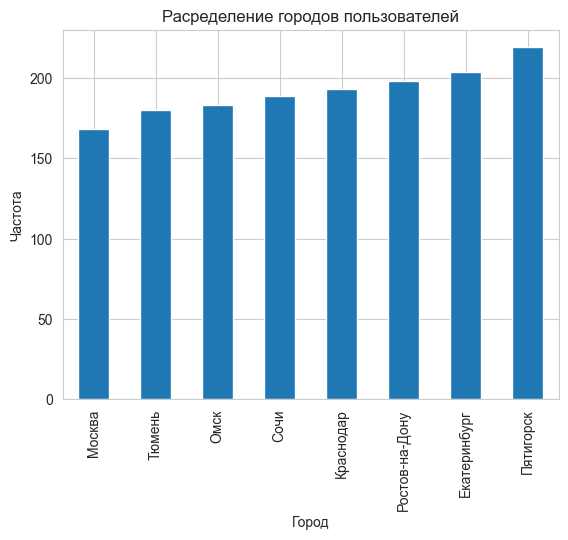

In [20]:
users.groupby('city')['user_id'].count().sort_values().plot(kind='bar',
      title='Расределение городов пользователей', 
      xlabel='Город', 
      ylabel='Частота');

В наших данных больше всего пользователей из Пятигорска, меньше всего - из Москвы

#### Соотношение пользователей с подпиской и без подписки;

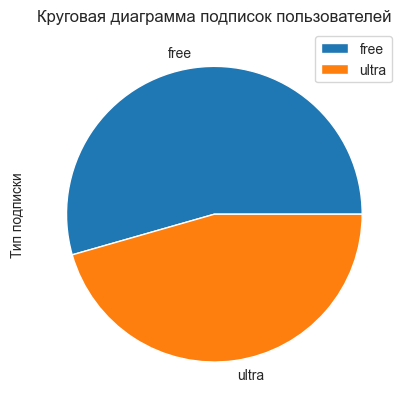

In [21]:
users.groupby('subscription_type')['user_id'].count().plot(
    kind='pie', 
    title='Круговая диаграмма подписок пользователей',
    ylabel='Тип подписки',
    legend=True);

Пользователей без подписок больше, чем с подпиской

#### Возраст пользователей

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64


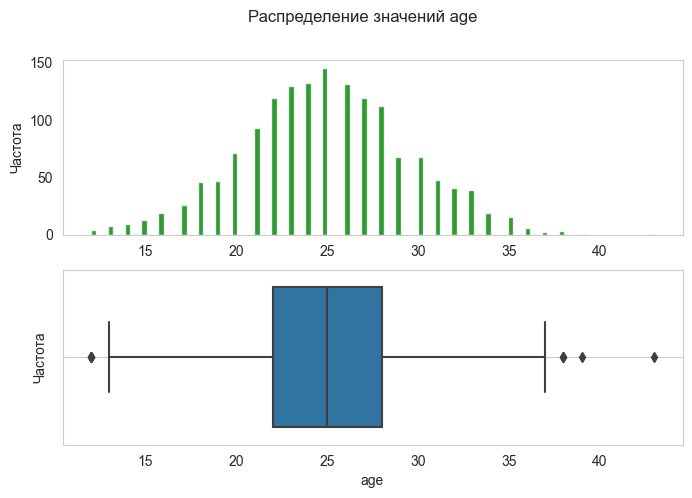

In [22]:
get_histogram_boxplot(users['age'])

Возраст пользователей имеет нормальное распределение. Средний возраст пользователей приложения - 25 лет.

#### Расстояние, которое пользователь преодолел за одну поездку

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64


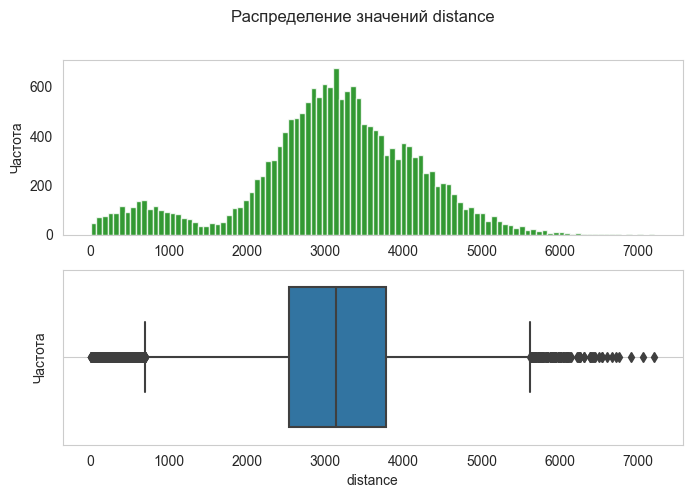

In [23]:
get_histogram_boxplot(rides['distance'])

Среднее расстояние, которое преодолевают пользователи - около 3100 метров. Есть слишком короткие расстояния - на графике видно, что около нуля есть значения.

#### Продолжительность поездок

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64


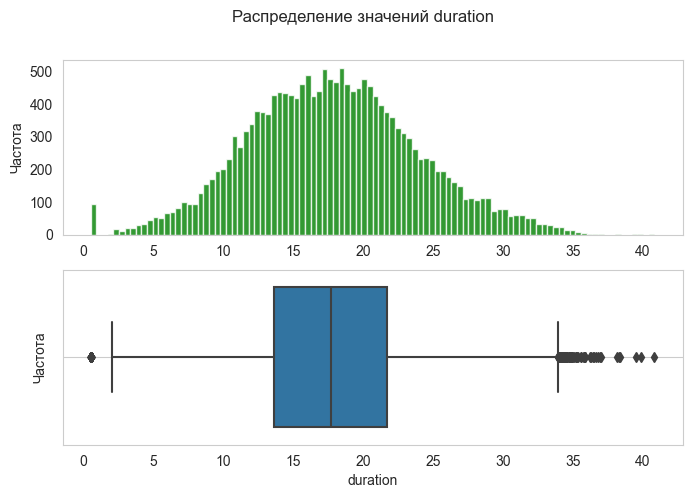

In [24]:
get_histogram_boxplot(rides['duration'])

Средняя продолжительность поездок - чуть более 17 минут. Распределение равномерное.

### Объединение данных

#### Объединим данные о пользователях, поездках и подписках в один датафрейм.

In [25]:
users_and_rides = users.merge(rides, on='user_id', how='right')

In [26]:
data = users_and_rides.merge(subscriptions, on='subscription_type', how='left')

In [27]:
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


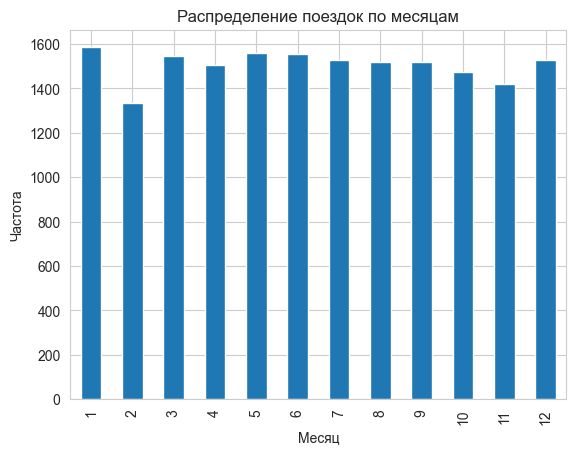

In [28]:
data.groupby('month')['month'].count().plot(kind='bar',
      title='Распределение поездок по месяцам',
      xlabel='Месяц',
      ylabel='Частота');

Интересно, что на самокатах катаются и зимой и летом примерно одинаково (небольшой спад наблюдается в феврале)

 Создадим ещё два датафрейма:
c данными о пользователях без подписки - data_free;
с данными о пользователях с подпиской - data_ultra.

In [29]:
data_ultra = data.query('subscription_type == "ultra"')
data_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [30]:
data_free = data.query('subscription_type == "free"').reset_index(drop=True)
data_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
1,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
2,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
3,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
4,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


##### Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

Построим график распределения расстояния сначала для пользователей с подпиской ultra, следом - пользователей с бесплатной подпиской

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64


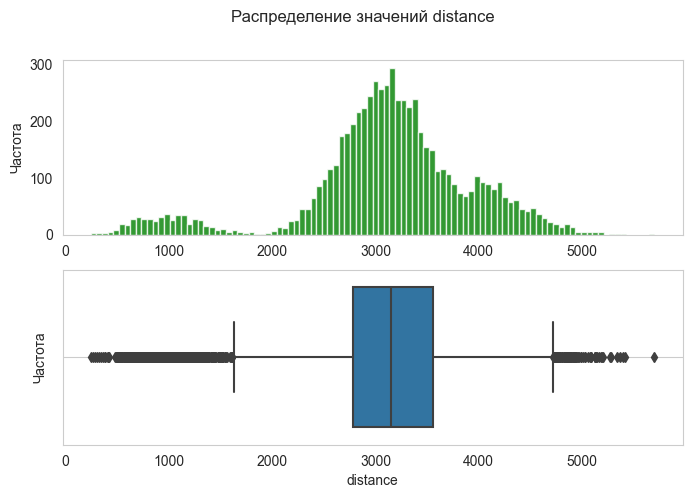

In [31]:
get_histogram_boxplot(data_ultra['distance'])

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64


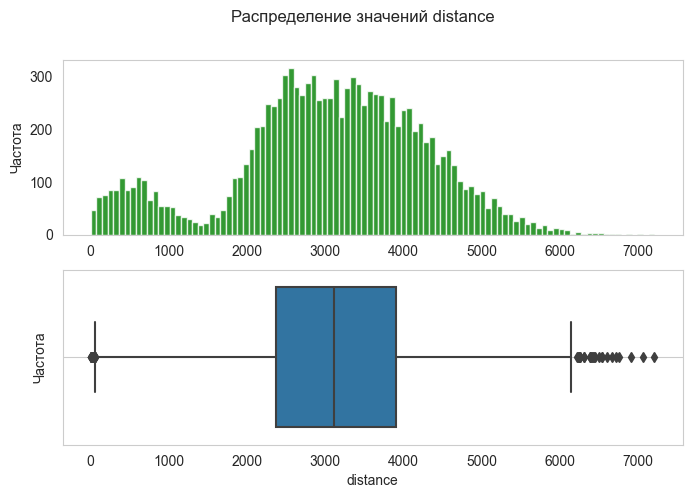

In [32]:
get_histogram_boxplot(data_free['distance'])

На обоих графиках есть небольшой пик до 2000 метров, после спад и уже основная масса.
У пользователей с платной подпиской коротких поездок (до 100 метров) почти нет, а вот среди пользователей с бесплатной подпиской таких поездок немало.

Так же можно заметить, что пользователи с бесплатной подпиской чаще ездят далее 5 км. Возможно, это связано с тем, что подписку берут люди для того, чтобы кататься иногда до работы от метро или от дома, а пользователи с бесплатной подпиской чаще разово катаются как туристы.

In [33]:
data[data['distance']<100]

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6611,707,Артём,27,Сочи,free,28.793204,14.143966,2021-09-12,9,8,50,0
6691,712,Дарья,28,Москва,free,23.963062,2.053251,2021-11-22,11,8,50,0
6816,721,Андрей,27,Пятигорск,free,62.568138,7.178766,2021-09-25,9,8,50,0
6850,724,Елизавета,23,Краснодар,free,30.473763,3.166221,2021-05-09,5,8,50,0
7367,760,Иван,22,Ростов-на-Дону,free,54.724068,8.164172,2021-10-13,10,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17414,1489,Алёна,30,Пятигорск,free,22.314412,6.074381,2021-10-06,10,8,50,0
17502,1495,Наталия,27,Омск,free,79.186579,9.237560,2021-05-16,5,8,50,0
17646,1506,Регина,29,Сочи,free,37.002836,4.170782,2021-06-27,6,8,50,0
17722,1511,Элина,27,Краснодар,free,87.430522,3.218576,2021-01-21,1,8,50,0


В целом, сложно найти взаимосвязь, почему такие поездки существуют. Возможно, люди думали, что это дешевле и перестали тратить время = деньги, возможно кто-то не смог научиться кататься и решил не продолжать кататься, а возможно, это технический сбой в отслеживании расстояния. Оснований для обработки таких значений нет. Люди действительно могли начать пользоваться приложением и быстро закончить, не проехав значительное расстояние. Оставим данные как есть.

Посмотрим, с чем может быть связан пик на расстоянии до 1500 метров.

In [34]:
data[data['distance']<1500]

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199
20,2,Станислав,31,Омск,ultra,923.007439,6.914760,2021-08-03,8,6,0,199
47,4,Константин,26,Ростов-на-Дону,ultra,724.559572,11.811399,2021-11-14,11,6,0,199
91,9,Ян,21,Пятигорск,ultra,979.657684,17.521497,2021-03-08,3,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18031,1532,Алексей,26,Тюмень,free,303.787850,7.792490,2021-05-21,5,8,50,0
18037,1532,Алексей,26,Тюмень,free,662.468186,9.528773,2021-11-18,11,8,50,0
18043,1533,Степан,22,Краснодар,free,310.488247,10.642389,2021-02-21,2,8,50,0
18049,1533,Степан,22,Краснодар,free,1034.998188,6.299996,2021-06-23,6,8,50,0


Посмотрим на доли городов с короткими (до 1500 метров) и с остальными поездками, возмодно в менее крупных городах доля поездок до 1500метров выше.

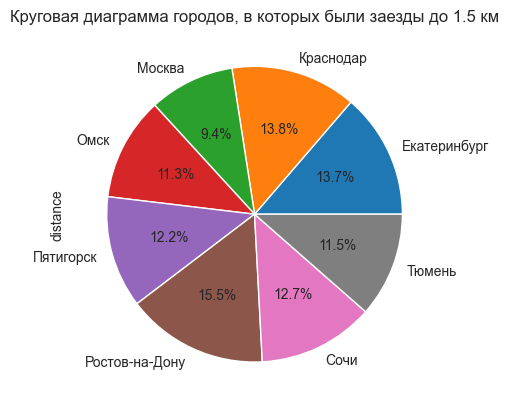

In [35]:
data[data['distance']<1500].groupby(['city'])['distance'].count().plot(
    kind='pie',
    title='Круговая диаграмма городов, в которых были заезды до 1.5 км',
    autopct='%1.1f%%'
);

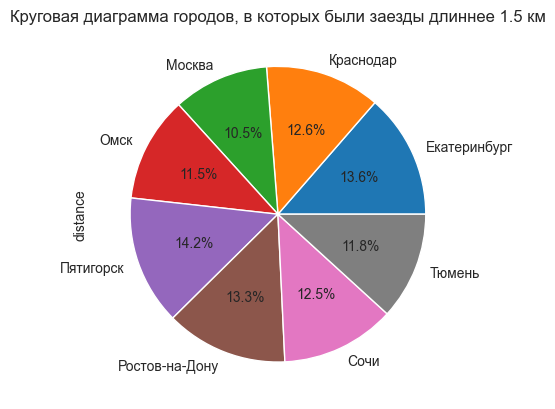

In [36]:
data[data['distance']>1500].groupby(['city'])['distance'].count().plot(
    kind='pie',
    title='Круговая диаграмма городов, в которых были заезды длиннее 1.5 км',
    autopct='%1.1f%%'
);

По графикам видно, что доли городов примерно одинаковые, вне зависимости от расстояния. Причин, по которым поездки могут быт короткими на первый взгляд нет.

Построим график распределения времени сначала для пользователей с подпиской ultra, следом - пользователей с бесплатной подпиской

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64


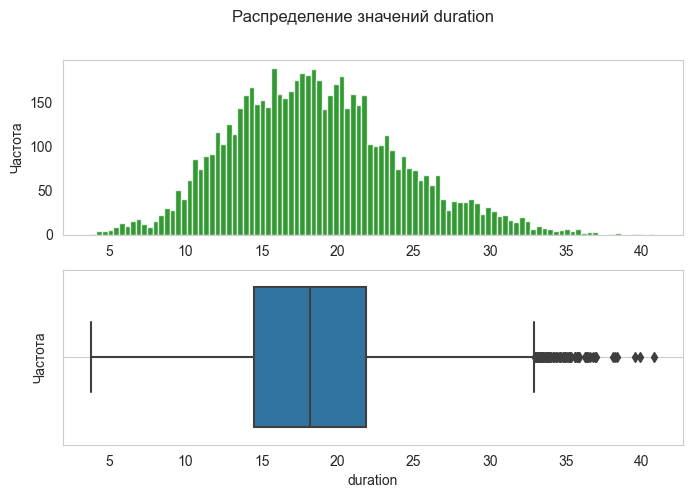

In [37]:
get_histogram_boxplot(data_ultra['duration'])

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64


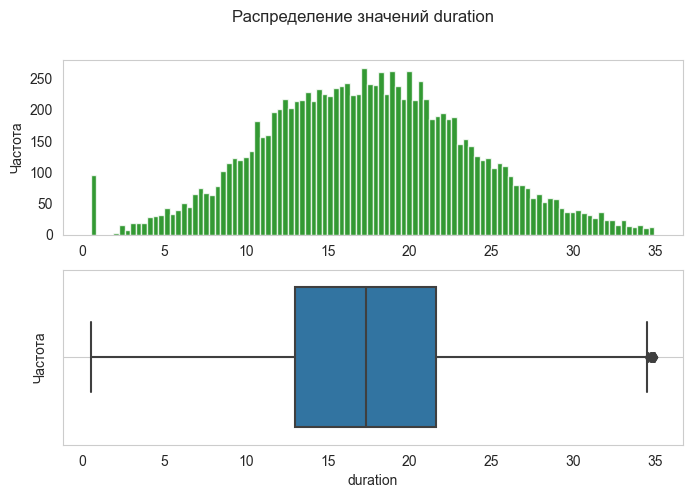

In [38]:
get_histogram_boxplot(data_free['duration'])

Пользователи с подпиской ultra в среднем катаются чуть дольше, чем пользователи с бесплатной подпиской. Значения с продолжительностью поездки = 0.5 минуты есть только среди пользователей с бесплатной подпиской. Возможно, это какой-то технический сбой, возможно, это какие-то мошеннические операции и есть лазейки в мобильном приложении, при котором идет отслеживание расстояния, но нет отслеживания времени. В любом случае необходимо рассказать разработчикам.

Так же посмотрим сами данные. Попробуем найти какие-то взаимосвязи в этих данных.

In [39]:
short_duration = data_free.query('duration <= 1')
short_duration

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
31,701,Иван,31,Екатеринбург,free,4196.445201,0.5,2021-08-31,8,8,50,0
70,704,Мирон,29,Ростов-на-Дону,free,4830.824371,0.5,2021-10-14,10,8,50,0
180,712,Дарья,28,Москва,free,4684.004397,0.5,2021-03-04,3,8,50,0
195,713,Святослав,30,Краснодар,free,5215.642710,0.5,2021-02-25,2,8,50,0
268,718,Владислава,31,Москва,free,5197.436649,0.5,2021-02-11,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10504,1460,Жанна,27,Пятигорск,free,5531.335845,0.5,2021-01-19,1,8,50,0
10742,1477,Ян,17,Сочи,free,6724.932981,0.5,2021-01-12,1,8,50,0
10814,1483,Роберт,26,Екатеринбург,free,4445.481070,0.5,2021-03-06,3,8,50,0
11005,1496,Яна,19,Москва,free,5722.551787,0.5,2021-02-14,2,8,50,0


Возможно, есть пользователи, у которых несколько поездок с коротким временем

In [40]:
short_duration['user_id'].duplicated().sum()

5

In [41]:
short_duration[short_duration['user_id'].isin(short_duration[short_duration['user_id'].duplicated()]['user_id'])]

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
3717,973,Александр,27,Омск,free,4578.711073,0.5,2021-03-01,3,8,50,0
3729,973,Александр,27,Омск,free,5052.769411,0.5,2021-11-27,11,8,50,0
4198,1007,Жанна,33,Пятигорск,free,5245.629783,0.5,2021-04-12,4,8,50,0
4199,1007,Жанна,33,Пятигорск,free,4633.256106,0.5,2021-04-27,4,8,50,0
7198,1224,Александр,25,Пятигорск,free,4430.510768,0.5,2021-01-15,1,8,50,0
7201,1224,Александр,25,Пятигорск,free,6414.516026,0.5,2021-07-15,7,8,50,0
7476,1243,Эдуард,31,Москва,free,4434.740681,0.5,2021-05-31,5,8,50,0
7479,1243,Эдуард,31,Москва,free,5095.432818,0.5,2021-12-02,12,8,50,0
9129,1364,Ян,31,Тюмень,free,4375.042408,0.5,2021-10-23,10,8,50,0
9136,1364,Ян,31,Тюмень,free,4697.638430,0.5,2021-12-20,12,8,50,0


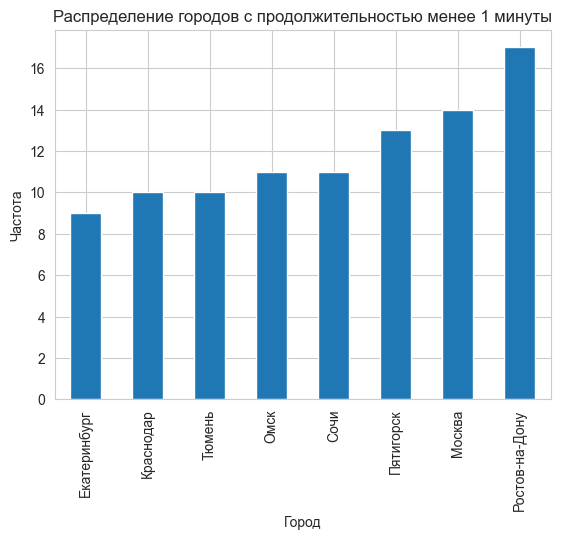

In [42]:
data_free.query('duration < 1').groupby('city')['city'].count().sort_values().plot(
    kind='bar',
    title='Распределение городов с продолжительностью менее 1 минуты',
    xlabel='Город',
    ylabel='Частота'
);

Такие заезды встречаются во всех городах. И видно, что это поездки, совершенные разными людьми.
Однако есть 5 людей, у кого по 2 такие поездки. Если это лазейки в системе, возможно они бы чаще этим пользовались.
В целом, очевидных взаимосвязей между этими поездками нет, но они явно не возможно, приблизим их к реальным цифрам. Заменим на среднее время поездки (необходимо будет умножить известное расстояние на медианную скорость поездки).

In [43]:
median_speed = data[data['duration']>1]['distance'].median()/data[data['duration']>1]['duration'].median()
median_speed

176.6403758331612

In [44]:
data.loc[data['duration']<1, 'duration'] = data['distance'].apply(lambda x: x/median_speed)
data[data['duration']<1]

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee


In [45]:
data_free.loc[data_free['duration']<1, 'duration'] = data_free['distance'].apply(lambda x: x/median_speed)
data_free.loc[data_free['duration']<1]

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee


In [46]:
data['duration'] = np.ceil(data['duration'])
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199


count    11568.000000
mean        17.624523
std          6.232196
min          2.035632
25%         13.127082
50%         17.446822
75%         21.779484
max         40.823100
Name: duration, dtype: float64


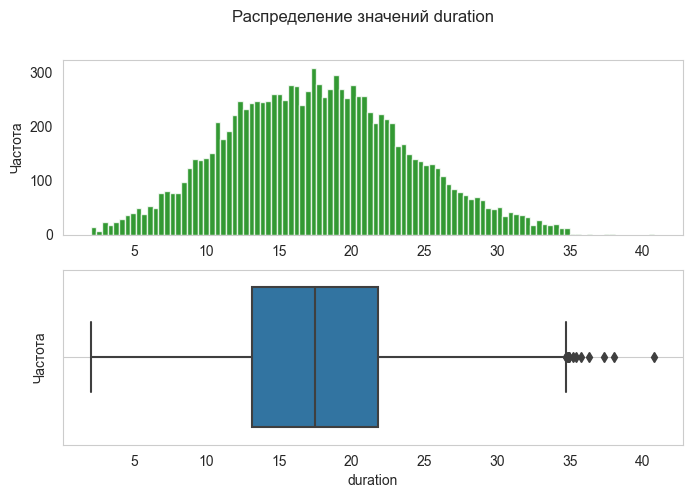

In [47]:
get_histogram_boxplot(data_free['duration'])

### Подсчёт выручки

*Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными: найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.*

In [48]:
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199


In [49]:
grouped_data = data.pivot_table(
    index=['user_id', 'month'],
    values=['distance', 'duration', 'subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee'],
    aggfunc={
        'distance': ['sum', 'count'],
        'duration': 'sum',
        'subscription_type': 'first',
        'minute_price': 'first',
        'start_ride_price': 'first',
        'subscription_fee': 'first'
    }).reset_index()

grouped_data.columns = ['user_id', 'month' , 'rides_count', 'distance_total', 'duration_total', 'minute_price', 'start_ride_price', 'subscription_fee', 'subscription_type']
grouped_data.head()

,user_id,month,rides_count,distance_total,duration_total,minute_price,start_ride_price,subscription_fee,subscription_type
0,1,1,2,7027.511294,42.0,6,0,199,ultra
1,1,4,1,754.159807,7.0,6,0,199,ultra
2,1,8,2,6723.470560,46.0,6,0,199,ultra
3,1,10,2,5809.911100,32.0,6,0,199,ultra
4,1,11,3,7003.499363,56.0,6,0,199,ultra


*В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратимся к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа.*

In [50]:
def n(row):
    return row['start_ride_price'] * row['rides_count'] + row['minute_price'] * row['duration_total'] + row['subscription_fee']

In [51]:
grouped_data['income'] = grouped_data.apply(n, axis=1)
grouped_data.head()

,user_id,month,rides_count,distance_total,duration_total,minute_price,start_ride_price,subscription_fee,subscription_type,income
0,1,1,2,7027.511294,42.0,6,0,199,ultra,451.0
1,1,4,1,754.159807,7.0,6,0,199,ultra,241.0
2,1,8,2,6723.470560,46.0,6,0,199,ultra,475.0
3,1,10,2,5809.911100,32.0,6,0,199,ultra,391.0
4,1,11,3,7003.499363,56.0,6,0,199,ultra,535.0


### Проверка гипотез

*Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу. Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.*

Предположим, то есть альтернативная гипотеза - что пользователи с подпиской тратят больше времени на поездки. Нулевая - пользователи тратят одинаково.

In [52]:
alpha = 0.05

ultra_users = data_ultra['duration']
free_users = data_free['duration']

ultra_users_mean = ultra_users.mean()
free_users_mean = free_users.mean()
ultra_users_std = (np.var(ultra_users))**0.5
free_users_std = (np.var(free_users))**0.5

results = st.ttest_ind(ultra_users, free_users, alternative='greater')

print(f'Mean duration of ultra users: {ultra_users_mean}')
print(f'Mean duration of free users: {free_users_mean}')
print(f'Standard deviation of ultra users: {ultra_users_std}')
print(f'Standard deviation of free users: {free_users_std}')
print(f'Statistic: {results.statistic}')
print(f'P-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Mean duration of ultra users: 18.54198516280583
Mean duration of free users: 17.62452336929048
Standard deviation of ultra users: 5.571619693672497
Standard deviation of free users: 6.2319267181734785
Statistic: 9.859262288648386
P-value: 3.5697754825886724e-23
Отвергаем нулевую гипотезу


pvalue очень маленький, то есть вероятность случайно получить такое и большее различие при верной нулевой гипотезе крайне мало. Таким образом, есть основания предполагать, что продолжительность поездок у людей с подпиской больше, чем у людей без подписки.

#### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверим гипотезу.

Нулевая гипотеза - расстояние меньше или равно 3130 метров. Альтернативная - расстояние более 3130 метров.

In [53]:
sample =  data[data['subscription_type'] == 'ultra']['distance']
interested_value = 3130
alpha = 0.05

mean = sample.mean()
std = (np.var(sample))**0.5

results = st.ttest_1samp(sample, interested_value, alternative = 'greater')

print(f'Mean: {mean}')
print(f'Standard deviation: {std}')
print(f'Statistic: {results.statistic}')
print(f'P-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Mean: 3115.4453880370247
Standard deviation: 836.8309511609637
Statistic: -1.402123166869486
P-value: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


p-value = 92%, нет оснований для отвержения нулевой гипотезы. Среднее значение выборки пользователей с подпиской = 3115, таким образом, предположение, что расстояние, которое проезжает в среднем меньше или равно 3130 метров не отвергается.

#### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.


Нулевая гипотеза - помесячная выручка от пользователей с подпиской равна выручке от пользователей с без подписки.
Альтернативная - что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 
Так как данные только за 2021 год, соберем данные для тестирования гипотез.

In [54]:
alpha = 0.05
ultra_months_income = grouped_data.loc[grouped_data['subscription_type'] == 'ultra']['income']
free_months_income = grouped_data.loc[grouped_data['subscription_type'] == 'free']['income']

ultra_users_mean = ultra_months_income.mean()
free_users_mean = free_months_income.mean()
ultra_users_std = (np.var(ultra_months_income))**0.5
free_users_std = (np.var(free_months_income))**0.5

results = st.ttest_ind(ultra_months_income, free_months_income, alternative='greater')

print(f'Mean income of ultra users: {ultra_users_mean}')
print(f'Mean income of free users: {free_users_mean}')
print(f'Standard deviation of ultra users: {ultra_users_std}')
print(f'Standard deviation of free users: {free_users_std}')
print(f'Statistic: {results.statistic}')
print(f'P-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Mean income of ultra users: 362.7921906022502
Mean income of free users: 331.8234774933804
Standard deviation of ultra users: 88.25300083333195
Standard deviation of free users: 185.15420613365453
Statistic: 10.49332693495557
P-value: 6.07594324062104e-26
Отвергаем нулевую гипотезу


P-value очень маленький, а значит вероятность случайно получить такую разницу между средними и больше крайне мала, таким образом мы отвергаем нулевую гипотезу в пользу альтернативной, и принимаем что средняя выручка от пользователей с подпиской больше, чем без подписки.

#### Шаг 7 Распределения


#### 7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Для каждого человека, который получил месяц бесплатно всего может быть 2 исхода - подписка продлена и подписка не продлена. Это - эксперимент Бернулли. В данном случае этот эксперимент одинаковый для всех 100 людей и подписка одного человека не влияет на подписку другого. Мы имеем дело с биномиальным распределением.

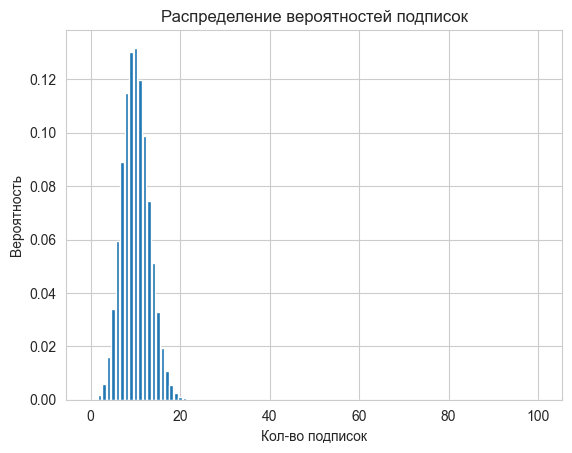

In [55]:
n = 100
p = 0.1
distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)

plt.bar(range(0, n + 1), distr);
plt.title('Распределение вероятностей подписок');
plt.xlabel('Кол-во подписок')
plt.ylabel('Вероятность')
plt.grid('True')

Как видим, вероятность получить значение более 20 подписок стремится к нулю. Методом проб найдем значение бесплатных подписок, которое нам нужно для того, чтобы с вероятностью 95% получить 100 подписок (или с вероятностью 5% получить менее 100 подписок)

In [56]:
n = 1171
p = 0.1
k=100

binom.cdf(k, n, p)

0.05052351990721414

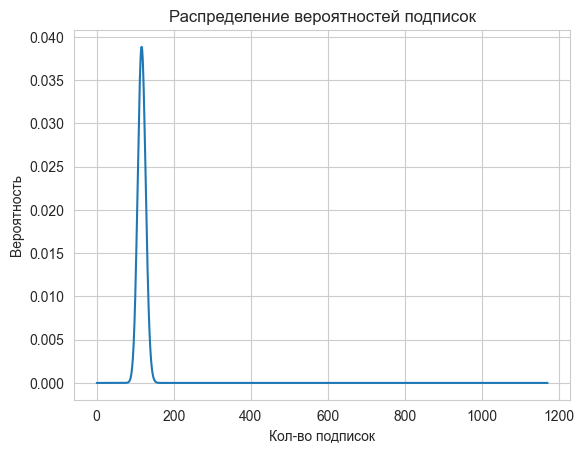

In [57]:
n = 1170
p = 0.1
distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)

plt.plot(range(0, n + 1), distr);
plt.title('Распределение вероятностей подписок');
plt.xlabel('Кол-во подписок')
plt.ylabel('Вероятность')
plt.grid('True')

После подбора получилось, что необходимо сделать 1171 бесплатных подписок, чтобы с вероятностью 95% получить 100 продлений подписок.

Мы проанализировали данные о пользователях приложения GoFast.

Произвели предобработку данных, посмотрели на разные параметры, построили графики, исследовали и проверили несколько гипотез.

Краткое описание данных:
В приложении есть 2 типа подписок - бесплатная и ultra. Всего около 1500 пользователей, из низ 699 с подпиской ultra и 835 с бесплатной подпиской. 

Пользователи без подписки чаще ездят далее 5 км, средняя продолжительность поездки = 17 минут, а среднее расстояние поездки = 3115 метров.

Пользователи с подпиской в среднем катаются чуть дольше, чем пользователи без подписки. Среднее время = 18 минут, а среднее расстояние поездки = 3150 метров.

Больше всего пользователей из Пятигорска, меньше всего - в Москве.

После проверки гипотез, были сделаны следующие выводы:  
В среднем, продолжительность поездок у людей с подпиской больше, чем у людей без подписки.  
3130 метров — оптимальное расстояние с точки зрения износа самоката. Пользователи с подпиской за одну поездку, в среднем проезжают менее 3130 метров.  
Cредняя выручка от пользователей с подпиской больше, чем без подписки.


В данных так же были странные значения, например есть поездки, которые длились 0.5 минут среди пользователей без подписки. А так же слишком короткие подписки среди бесплатных пользователей. Возможно, есть лазейки в приложении, позволяющие сбрасывать счетчик, либо это технический сбой - желательно проверить эти данные на стороне заказчика.